## Use Folder Dataset (for Custom Datasets) via API

Here we show how one can utilize custom datasets to train anomalib models. A custom dataset in this model can be of the following types:

- A dataset with good and bad images.
- A dataset with good and bad images as well as mask ground-truths for pixel-wise evaluation.
- A dataset with good and bad images that is already split into training and testing sets.

To experiment this setting we provide a toy dataset that could be downloaded from the following [https://github.com/openvinotoolkit/anomalib/blob/main/docs/source/data/hazelnut_toy.zip](link). For the rest of the tutorial, we assume that the dataset is downloaded and extracted to `../../datasets`, located in the `anomalib` directory.

### ! need to rerun next block after **first install**

In [1]:
!pip install anomalib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!git clone https://github.com/openvinotoolkit/anomalib.git

Cloning into 'anomalib'...
remote: Enumerating objects: 22465, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 22465 (delta 85), reused 85 (delta 45), pack-reused 22325
Receiving objects: 100% (22465/22465), 52.39 MiB | 27.72 MiB/s, done.
Resolving deltas: 100% (13413/13413), done.


In [2]:
from pathlib import Path
from typing import Any, Dict

import numpy as np
from IPython.display import display
from PIL import Image
from pytorch_lightning import Trainer
from torchvision.transforms import ToPILImage

from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.models import get_model
from anomalib.pre_processing.transforms import Denormalize
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks

In [3]:
import numpy as np
from PIL import Image
from torchvision.transforms import ToPILImage

from anomalib.data.folder import Folder, FolderDataset
from anomalib.pre_processing import PreProcessor
from anomalib.pre_processing.transforms import Denormalize

from functools import partial, update_wrapper
from types import MethodType
from typing import Any

from matplotlib import pyplot as plt
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from torch.optim import Optimizer
from torch.optim.adam import Adam
from torch.utils.data import DataLoader

from anomalib.data import InferenceDataset
from anomalib.models.patchcore.lightning_model import Patchcore
from anomalib.post_processing import superimpose_anomaly_map
from anomalib.pre_processing.transforms import Denormalize
from anomalib.utils.callbacks import (
    ImageVisualizerCallback,
    MetricsConfigurationCallback,
    MetricVisualizerCallback,
    MinMaxNormalizationCallback,
)

In [4]:
# import the dataset from the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prepare imagenette(dog:normal, rest:abnormal)

In [6]:
import os
rootdir="/content/drive/MyDrive/data/dog/train/normal"
files=os.listdir(rootdir)
print(len(files),"len")
for filename in files:
  portion=os.path.splitext(filename)
  if portion[1]==".JPEG":
    newname=portion[0]+".jpg"
    os.chdir(rootdir)
    os.rename(filename,newname)

955 len


In [5]:
import os
rootdir="/content/drive/MyDrive/data/dog/train/abnormal"
files=os.listdir(rootdir)
print(len(files),"len")
for filename in files:
  portion=os.path.splitext(filename)
  if portion[1]==".JPEG":
    newname=portion[0]+".jpg"
    os.chdir(rootdir)
    os.rename(filename,newname)

930 len


In [7]:
# get help command: PreProcessor??
pre_process = PreProcessor(image_size=256, to_tensor=True)

In [8]:
imagenette_datamodule = Folder(
    root="/content/drive/MyDrive/data/dog/train",
    normal_dir="normal",
    abnormal_dir="abnormal",
    task="classification",
    seed=0,
    image_size=256,
)
imagenette_datamodule.setup()

In [55]:
# Train images
i, data = next(enumerate(imagenette_datamodule.train_dataloader()))
data.keys(), data["image"].shape

(dict_keys(['image']), torch.Size([32, 3, 256, 256]))

In [ ]:
# Test images
i, data = next(enumerate(PED2_datamodule.test_dataloader()))
data.keys(), data["image"].shape, data["label"].shape

(dict_keys(['image', 'image_path', 'label']),
 torch.Size([32, 3, 256, 256]),
 torch.Size([32]))

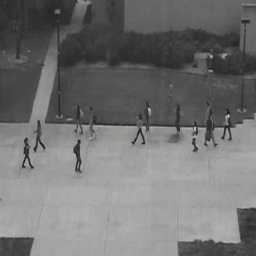

In [ ]:
img = ToPILImage()(Denormalize()(data["image"][0].clone()))
img

## PADIM model

In [18]:
CONFIG_PATH2 = f"/content/drive/MyDrive/padim/dog_padim_config.yaml"
with open(file=CONFIG_PATH2, mode="r", encoding="utf-8") as file:
    print(file.read())

dataset:
  name: folder #options: [mvtec, btech, folder]
  format: folder
  path: /content/drive/MyDrive/data/dog/train
  task: classification
  normal_dir: normal
  abnormal_dir: abnormal
  normal_test_dir: null
  extensions: null
  split_ratio: 0.2
  image_size: 256
  train_batch_size: 32
  test_batch_size: 32
  num_workers: 8
  transform_config:
    train: null
    val: null
  create_validation_set: true
  tiling:
    apply: False
    tile_size: null
    stride: null
    remove_border_count: 0
    use_random_tiling: False
    random_tile_count: 16

model:
  name: padim
  backbone: resnet18
  pre_trained: true
  layers:
    - layer1
    - layer2
    - layer3
  normalization_method: min_max # options: [none, min_max, cdf]

metrics:
  image:
    - F1Score
    - AUROC
  pixel:
    - F1Score
    - AUROC
  threshold:
    image_default: 0
    pixel_default: 0
    adaptive: true

visualization:
  show_images: False # show images on the screen
  save_images: True # save images to the file sy

In [19]:
config2 = get_configurable_parameters(config_path=CONFIG_PATH2)

In [20]:
model2 = get_model(config2)
callbacks2 = get_callbacks(config2)

In [21]:
trainer2 = Trainer(**config2.trainer, callbacks=callbacks2)
trainer2.fit(model=model2, datamodule=imagenette_datamodule)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch.

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [22]:
# load best model from checkpoint before evaluating
load_model_callback = LoadModelCallback(weights_path=trainer2.checkpoint_callback.best_model_path)
trainer2.callbacks.insert(0, load_model_callback)
trainer2.test(model=model2, datamodule=imagenette_datamodule)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       image_AUROC          0.6965208649635315
      image_F1Score          0.908450722694397
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'image_F1Score': 0.908450722694397, 'image_AUROC': 0.6965208649635315}]

In [12]:
image_filenames = list(Path(config2["project"]["path"]).glob("**/*.png"))
print(image_filenames[0])

/content/drive/MyDrive/results/padim_dog/padim/folder/images/image_ROC.png


In [ ]:
for filename in image_filenames:
    image = Image.open(filename)
    display(image)

# PaDiM Inference 

In [23]:
from anomalib.data import InferenceDataset

In [37]:
inference_dataset = InferenceDataset(
    path="/content/drive/MyDrive/data/dog/train/normal/ILSVRC2012_val_00017664.jpg", image_size=(256, 256)
)
inference_dataloader = DataLoader(dataset=inference_dataset)

In [38]:
inference_dataset2 = InferenceDataset(
    path="/content/drive/MyDrive/data/dog/train/abnormal/ILSVRC2012_val_00006697.jpg", image_size=(256, 256)
)
inference_dataloader2 = DataLoader(dataset=inference_dataset2)

In [39]:
predictions = trainer2.predict(model=model2, dataloaders=inference_dataloader)[0]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Predicting: 24it [00:00, ?it/s]

In [40]:
predictions2 = trainer2.predict(model=model2, dataloaders=inference_dataloader2)[0]

Predicting: 24it [00:00, ?it/s]

In [ ]:
print(predictions.keys())

dict_keys(['image', 'image_path', 'anomaly_maps', 'pred_scores', 'pred_labels', 'pred_masks'])


In [ ]:
print(
    f'Image Shape: {predictions["image"].shape},\n'
    'Anomaly Map Shape: {predictions["anomaly_maps"].shape}, \n'
    'Predicted Mask Shape: {predictions["pred_masks"].shape}'
)

Image Shape: torch.Size([1, 3, 256, 256]),
Anomaly Map Shape: {predictions["anomaly_maps"].shape}, 
Predicted Mask Shape: {predictions["pred_masks"].shape}


In [41]:
image = predictions["image"][0]
image = Denormalize()(image)
print(f"Image Shape: {image.shape}\n Min Pixel: {image.min()} \n Max Pixel: {image.max()}")

Image Shape: (256, 256, 3)
 Min Pixel: 103 
 Max Pixel: 182


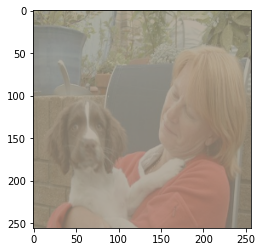

In [42]:
plt.imshow(image)

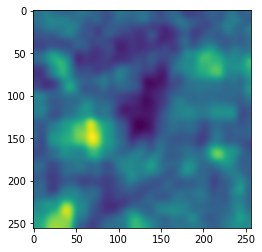

In [43]:
anomaly_map = predictions["anomaly_maps"][0]
anomaly_map = anomaly_map.cpu().numpy().squeeze()
plt.imshow(anomaly_map)

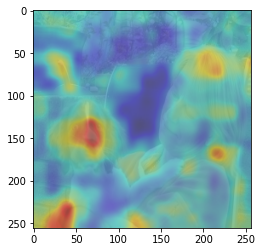

In [44]:
heat_map = superimpose_anomaly_map(anomaly_map=anomaly_map, image=image, normalize=True)
plt.imshow(heat_map)

In [45]:
image2 = predictions2["image"][0]
image2 = Denormalize()(image2)
print(f"Image Shape: {image2.shape}\n Min Pixel: {image2.min()} \n Max Pixel: {image2.max()}")

Image Shape: (256, 256, 3)
 Min Pixel: 103 
 Max Pixel: 182


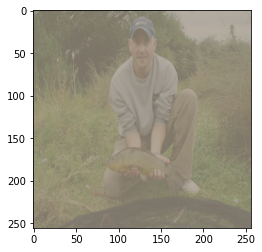

In [46]:
plt.imshow(image2)

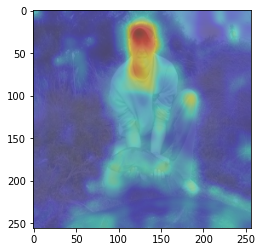

In [47]:
anomaly_map2 = predictions2["anomaly_maps"][0]
anomaly_map2 = anomaly_map2.cpu().numpy().squeeze()
plt.imshow(anomaly_map2)
heat_map2 = superimpose_anomaly_map(anomaly_map=anomaly_map2, image=image2, normalize=True)
plt.imshow(heat_map2)

# STFPM model with imagenette

In [50]:
CONFIG_PATH3 = f"/content/drive/MyDrive/stfpm/custom_config.yaml"
with open(file=CONFIG_PATH3, mode="r", encoding="utf-8") as file:
    print(file.read())

dataset:
  name: folder #options: [mvtec, btech, folder]
  format: folder
  path: /content/drive/MyDrive/data/dog/train
  task: classification
  normal_dir: normal
  abnormal_dir: abnormal
  normal_test_dir: null
  extensions: null
  split_ratio: 0.2
  image_size: 256
  train_batch_size: 32
  test_batch_size: 32
  inference_batch_size: 32
  num_workers: 36
  transform_config:
    train: null
    val: null
  create_validation_set: true
  tiling:
    apply: false
    tile_size: null
    stride: null
    remove_border_count: 0
    use_random_tiling: False
    random_tile_count: 16

model:
  name: stfpm
  backbone: resnet18
  layers:
    - layer1
    - layer2
    - layer3
  lr: 0.4
  momentum: 0.9
  weight_decay: 0.0001
  early_stopping:
    patience: 3
    metric: image_F1Score
    mode: max
  normalization_method: min_max # options: [null, min_max, cdf]

metrics:
  image:
    - F1Score
    - AUROC
  pixel:
    - F1Score
    - AUROC
  threshold:
    image_default: 0
    pixel_default: 0
 

In [51]:
config3 = get_configurable_parameters(config_path=CONFIG_PATH3)

In [52]:
model3 = get_model(config3)
callbacks3 = get_callbacks(config3)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [53]:
trainer3 = Trainer(**config3.trainer, callbacks=callbacks3)
trainer3.fit(model=model3, datamodule=imagenette_datamodule)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch.

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [54]:
# load best model from checkpoint before evaluating
load_model_callback = LoadModelCallback(weights_path=trainer3.checkpoint_callback.best_model_path)
trainer3.callbacks.insert(0, load_model_callback)
trainer3.test(model=model3, datamodule=imagenette_datamodule)

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       image_AUROC          0.7316500544548035
      image_F1Score         0.9111891388893127
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'image_F1Score': 0.9111891388893127, 'image_AUROC': 0.7316500544548035}]

/content/drive/MyDrive/results/stfpm/stfpm/folder/images/image_ROC.png


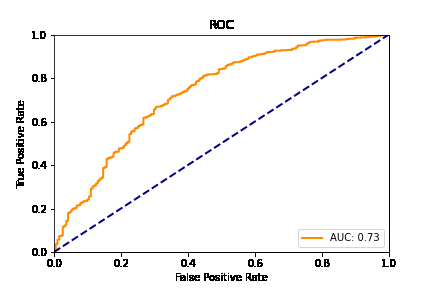

In [55]:
image_filenames = list(Path(config3["project"]["path"]).glob("**/*.png"))
print(image_filenames[0])
for filename in image_filenames:
    image = Image.open(filename)
    display(image)

# Inference from STFPM

In [ ]:
from anomalib.data import InferenceDataset

In [56]:
predictions3 = trainer3.predict(model=model3, dataloaders=inference_dataloader)[0]
predictions4 = trainer3.predict(model=model3, dataloaders=inference_dataloader2)[0]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Predicting: 24it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping


Predicting: 24it [00:00, ?it/s]

In [57]:
image3 = predictions3["image"][0]
image3 = Denormalize()(image3)
print(f"Image Shape: {image3.shape}\n Min Pixel: {image3.min()} \n Max Pixel: {image3.max()}")

Image Shape: (256, 256, 3)
 Min Pixel: 103 
 Max Pixel: 182


In [58]:
image4 = predictions4["image"][0]
image4 = Denormalize()(image4)
print(f"Image Shape: {image4.shape}\n Min Pixel: {image4.min()} \n Max Pixel: {image4.max()}")

Image Shape: (256, 256, 3)
 Min Pixel: 103 
 Max Pixel: 182


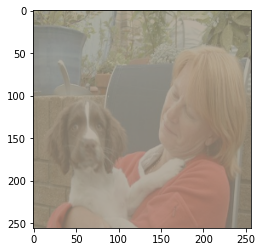

In [60]:
plt.imshow(image3)


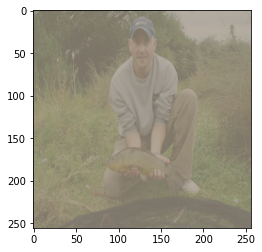

In [61]:
plt.imshow(image4)

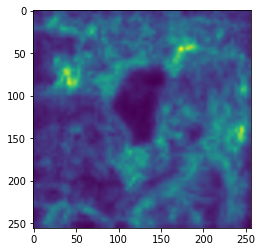

In [62]:
anomaly_map3 = predictions3["anomaly_maps"][0]
anomaly_map3 = anomaly_map3.cpu().numpy().squeeze()
plt.imshow(anomaly_map3)

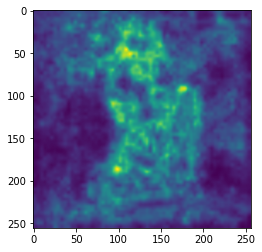

In [63]:
anomaly_map4 = predictions4["anomaly_maps"][0]
anomaly_map4 = anomaly_map4.cpu().numpy().squeeze()
plt.imshow(anomaly_map4)

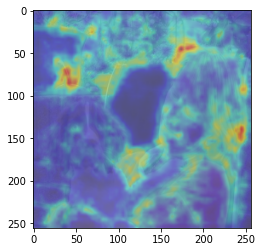

In [64]:
heat_map3 = superimpose_anomaly_map(anomaly_map=anomaly_map3, image=image3, normalize=True)
plt.imshow(heat_map3)

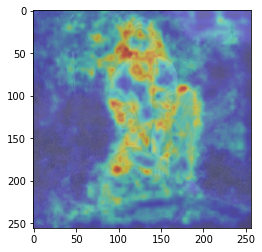

In [65]:
heat_map4 = superimpose_anomaly_map(anomaly_map=anomaly_map4, image=image4, normalize=True)
plt.imshow(heat_map4)